In [1]:
#Import library
#Data preprocessing
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import ngrams
import re

#Visualization
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
#Feature Engineering
import string
import re
from keras._tf_keras.keras.preprocessing.text import Tokenizer
from keras._tf_keras.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

#Machine Learning Model
from sklearn.model_selection import train_test_split
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.layers import Dense,LSTM,Embedding,Dropout,Activation,Bidirectional,Input
import tensorflow as tf
from keras._tf_keras.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
#Evaluation Metric
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score
import seaborn as sns

In [2]:
#Load the dataset
df=pd.read_csv("email_text.csv")
df.head(5)

,label,text
0,1,do you feel the pressure to perform and not ri...
1,0,hi i've just updated from the gulus and i chec...
2,1,mega authenticv i a g r a discount pricec i a ...
3,1,hey billy it was really fun going out the othe...
4,1,system of the home it will have the capabiliti...


在提供的数据集中，标签'1'表示电子邮件被分类为垃圾邮件，而标签'0'表示电子邮件是合法的（非垃圾邮件）。我们可以利用这些信息来训练一个分类模型，用于预测一封电子邮件是垃圾邮件还是合法邮件。

检查缺失值

In [3]:
print(df.isnull().sum())

label    0
text     0
dtype: int64


检查数据的形状

In [4]:
df.shape

(53668, 2)

将文本转换为小写字母

In [5]:
df['text'] = df['text'].str.lower()

去除数字和特殊字符

在区分垃圾邮件和合法邮件时。这一步有助于减少噪音，集中精力在文本中的有意义的词汇和模式上。

In [6]:
def remove_special_characters(word):
    return word.translate(str.maketrans('', '', string.punctuation))
df['text'] = df['text'].apply(remove_special_characters)

去除英文停用词

像 'the'、'a' 等停用词可以从文本中删除，因为它们不提供有价值的信息。

In [7]:
#Define stop-words in English
ENGLISH_STOP_WORDS = set(stopwords.words('english'))

def remove_stop_words(words):
    return [word for word in words if word not in ENGLISH_STOP_WORDS]

#Tokenize the text
df['text'] = df['text'].apply(word_tokenize)

#Remove stop words
df['text'] = df['text'].apply(remove_stop_words)

#Rejoin words for EDA
df['text'] = df['text'].apply(' '.join)

去除超链接

一些电子邮件中包含 URL，这些 URL 并不提供有价值的信息。

In [8]:
def remove_hyperlink(word):
    return re.sub(r"http\S+", "", word)

df['text'] = df['text'].apply(remove_hyperlink)

探索性数据分析
让我们以一个垃圾短信为例进行检查


In [9]:
for i in range (1,3):
    print("Email #"+str(i))
    spam_email = df[df['label'] == 1]['text'].iloc[i]
    print(spam_email+"\n")

Email #1
mega authenticv g r discount pricec l discount pricedo miss click http www moujsjkhchum com

Email #2
hey billy really fun going night talking said felt insecure manhood noticed toilets quite small area worry website telling secret weapon extra escapenumber inches trust girls love bigger ones ive escapenumber times many chicks since used pills year ago package used escapenumber month supply one worth every cent website http ctmay com ring weekend go drink let know secrets later dude brad



为什么这些邮件被分类为垃圾邮件？
邮件1：药品促销

未经请求的广告：该邮件推广诸如Viagra、Levitra、Cialis等药物，这是垃圾邮件中常见的主题。
随机词语和短语：邮件中包含一些随机词语和药品名称，这通常是垃圾邮件用来绕过过滤器的策略。
可疑链接：提到的网站链接购买药品是一个警示信号。正规的制药公司通常不会以这种方式推销其产品。
不规则的格式：使用随机字符和不一致的间距（例如“wulvob”，“qnb ikud”）是垃圾邮件常见的特征，用来逃避检测算法。
缺乏个性化：邮件内容泛泛而谈，没有直接称呼任何收件人，暗示这是一封群发邮件。
邮件2：提供大学学位

虚假承诺：提供无需测试、课程、书籍或考试的大学学位，这是不现实的，典型的教育诈骗邮件。
匿名性：邮件保证保密性，但没有提及任何正规大学的名称。
全天候服务：声称“全天24小时，一周7天”的服务，这不是正规教育机构的常态。
缺乏具体细节：邮件对于学位性质和获取过程含糊不清，这是垃圾邮件的特征之一。

因此，垃圾邮件的主要特征通常是：

未经请求的广告: 垃圾邮件通常在未获得收件人事先同意的情况下推广产品或服务。

随机和不规则的文本: 它们经常包含随机的词语、短语和字符，以逃避垃圾邮件过滤器。

欺骗性优惠: 垃圾邮件常常包含不现实或过于美好的优惠，如快速获取学位或廉价药品。

缺乏个性化: 这些邮件通常是泛泛而谈，没有直接称呼或个性化内容，显示出群发的特征。

可疑链接或指示: 它们通常包含可疑的链接或不明确的指示，可能导致钓鱼网站或骗局。

内容不连贯: 垃圾邮件中的内容通常是支离破碎的，缺乏清晰、一致的信息或目的。

**Let check with an example of a legitimate text**


In [10]:
for i in range (1,3):
    print("Email #"+str(i))
    legitimate_email = df[df['label'] == 0]['text'].iloc[i]
    print(legitimate_email+"\n")

Email #1
hi use r find escapenumber confidence interval sensitivity specificity following diagnostic test particular diagnostic test multiple sclerosis conducted escapenumber ms patients escapenumber healthy subjects escapenumber ms patients classified healthy escapenumber healthy subjects classified suffering ms furthermore need find number ms patients required sensitivity escapenumber simple r command completely new r help please jochen view message context http www nabble com confidence intervals help tfescapenumber html aescapenumber sent r help mailing list archive nabble com r help stat math ethz ch mailing list  stat ethz ch mailman listinfo r help please read posting guide http www r project org posting guide html provide commented minimal self contained reproducible code

Email #2
hm sounds like homework problem maybe start figuring without r whats approach would calculate search r help possible key words came sarah escapenumber escapenumber escapenumber jochen f wrote hi use 

为什么这些邮件被分类为合法的？

邮件 1：技术讨论

具体且相关的内容：邮件包含关于使用 rsync（一种合法的软件工具）的详细技术信息，表明这是一个特定的、有目的的讨论。
个性化和背景相关：邮件是对话的一部分，提到了之前的消息和特定的个人，显示出其针对性和对收件人的相关性。
专业语气：语言和结构专业，专注于特定的技术主题，这在合法的通信中很常见。
没有未经请求的优惠或链接：没有不合时宜的推广或可疑链接，这在垃圾邮件中很常见。
邮件 2：合法推广

官方沟通：这封邮件来自CNN，一个知名的组织，推广的是预定的节目，这是媒体公司正常的做法。
清晰、相关的信息：提供了关于特定事件（采访迈克尔·摩尔）的详细信息以及如何参与，表明其合法性。
确认同意接收：提到收件人已经同意接收此类邮件，表明这是合法订阅的一部分。
明确的退订选项：存在明确的退订选项，是合法营销活动的标志。

因此，合法邮件的主要特征通常是：

相关和具体的内容：合法邮件通常包含与发件人和收件人共同的上下文或兴趣相关的详细具体信息。

个性化的沟通：它们通常直接称呼收件人或提到之前的互动，显示出个性化和有针对性的方式。

专业和连贯的语气：合法邮件通常使用专业、连贯的语言和语气，与主题相符。

与已知实体的关联：它们通常与已知的组织或实体有关联，提供了一层真实性。

选择加入和退订选项：合法的商业或促销邮件通常包括明确的选择加入和退订选项，尊重收件人的偏好。

没有可疑的链接或优惠：与垃圾邮件不同，合法邮件通常不包含未经请求的优惠、误导性链接或索要敏感信息的请求。

当然，这里是一个对比垃圾邮件和合法邮件的图表，展示它们的主要特征：

| 特征                          | 垃圾邮件 (Spam Email)                                                                            | 合法邮件 (Legitimate Email)                                                                                     |
|-------------------------------|--------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------|
| **内容相关性**                | 通常包含与收件人无关的泛泛信息或推销产品。                                                       | 包含与发件人和收件人共同上下文或兴趣相关的详细、具体信息。                                                         |
| **个性化程度**               | 通常是群发邮件，缺乏个性化，没有提及个人信息或之前的互动。                                          | 通常直接称呼收件人，并提到之前的互动，显示个性化和有针对性的方式。                                                |
| **语气和语言**               | 可能包含语法错误、拼写错误或不连贯的句子，语气不专业。                                              | 使用专业、连贯的语言和语气，与主题相符。                                                                         |
| **发送者身份**               | 发送者通常是未知或可疑的组织，难以验证其真实性。                                                    | 通常与已知或可信的组织有关联，容易验证其真实性。                                                                 |
| **选择加入和退订选项**       | 很少或根本没有提供合法的选择加入或退订选项。                                                       | 通常包括明确的选择加入和退订选项，尊重收件人的偏好。                                                             |
| **链接和优惠**               | 可能包含可疑或误导性的链接、未经请求的优惠或要求提供敏感信息。                                         | 很少包含未经请求的优惠，没有可疑链接或要求提供敏感信息。                                                          |
| **视觉设计**                 | 可能设计粗糙，不一致的格式和配色，有时甚至包含低质量的图片。                                            | 视觉设计通常专业，格式和配色一致，图片质量高。                                                                   |
| **紧迫感**                   | 常常使用紧迫感（如“立即行动”，“机会有限”）来诱使收件人快速反应。                                      | 通常不会过度强调紧迫感，更注重提供信息和选择，让收件人自己决定是否采取行动。                                      |
| **附件**                      | 可能包含恶意软件或病毒的附件，具有潜在风险。                                                         | 如果有附件，通常是与邮件内容相关的安全文件，如PDF报告、合同等。                                                    |

这个图表总结了垃圾邮件和合法邮件之间的主要区别，帮助识别和区分这两种类型的电子邮件。

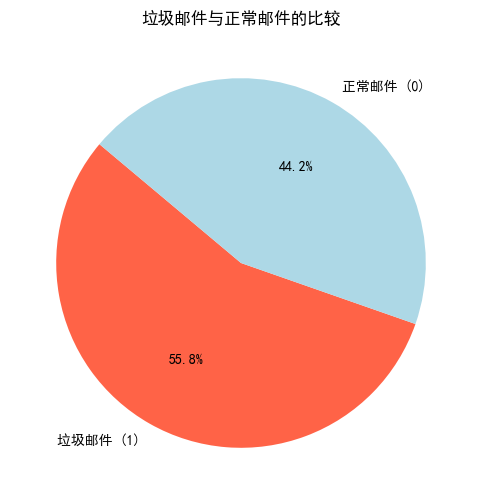

In [11]:
# Count the number of spam and legitimate emails
email_counts = df['label'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
plt.pie(email_counts, labels = ['垃圾邮件 (1)', '正常邮件 (0)'], autopct='%1.1f%%', startangle=140, colors=['tomato', 'lightblue'])
plt.title('垃圾邮件与正常邮件的比较')
plt.show()

图表显示，52.6%的邮件被分类为垃圾邮件，而47.4%的邮件被分类为合法邮件。这种几乎均等的划分表明数据集在这两类之间是相对平衡的，这对于训练机器学习模型非常有利，因为它减少了模型偏向某一类的风险。

词频分析

制作一个柱状图，展示垃圾邮件和合法邮件中最常见的词语。

In [12]:
# Separate the spam and legitimate emails
spam_emails = df[df['label'] == 1]['text']
legit_emails = df[df['label'] == 0]['text']

# Count word frequencies for spam
spam_words = Counter()
spam_emails.apply(lambda x: spam_words.update(x.split()))

# Count word frequencies for legitimate emails
legit_words = Counter()
legit_emails.apply(lambda x: legit_words.update(x.split()))

# Get the most common words in spam and legitimate emails
spam_common = spam_words.most_common(10)
legit_common = legit_words.most_common(10)

# Convert to DataFrame
spam_common_df = pd.DataFrame(spam_common, columns=['Word', 'Frequency'])
legit_common_df = pd.DataFrame(legit_common, columns=['Word', 'Frequency'])

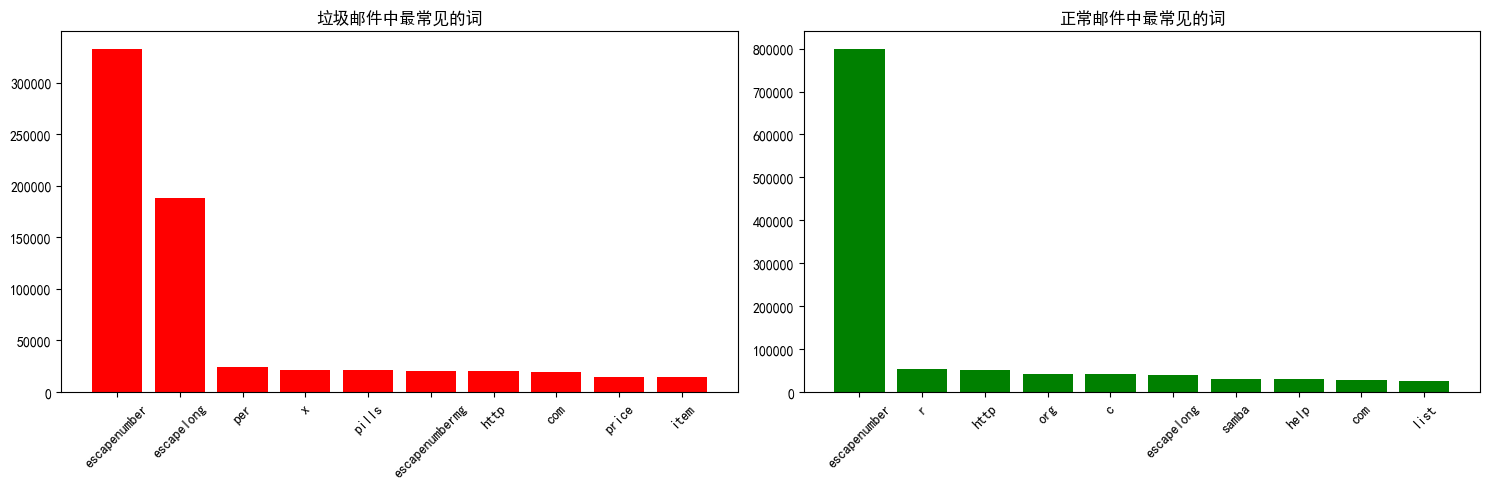

In [13]:
plt.figure(figsize=(15, 5))

# 绘制垃圾邮件中最常见的词
plt.subplot(1, 2, 1)
plt.bar(spam_common_df['Word'], spam_common_df['Frequency'], color='red')
plt.title('垃圾邮件中最常见的词')
plt.xticks(rotation=45)

# 绘制正常邮件中最常见的词
plt.subplot(1, 2, 2)
plt.bar(legit_common_df['Word'], legit_common_df['Frequency'], color='green')
plt.title('正常邮件中最常见的词')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


**词云**

垃圾邮件和非垃圾邮件的词云有助于可视化每个类别中最常见的词语。

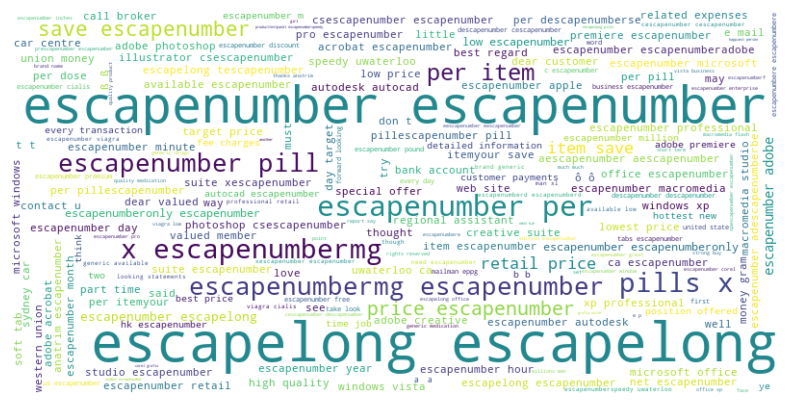

In [14]:
# Generate a word cloud image for spam words
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(spam_emails))

# Display the image
plt.figure(figsize=(10, 5))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**N-gram 分析**

N-gram 分析的目的是探索垃圾邮件和合法邮件中最常见的二词或三词序列。这有助于理解两种类型邮件中常用的短语。

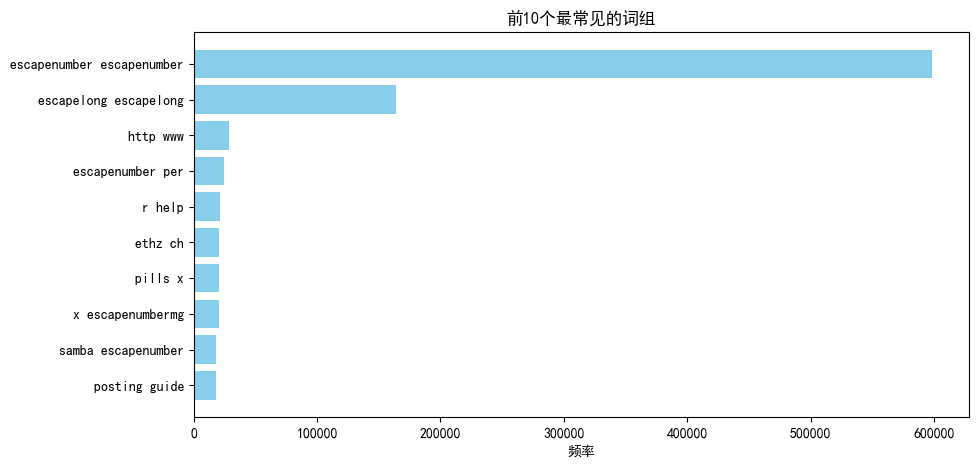

In [15]:
# Extract n-grams from text
def generate_ngrams(text, n=2):
    # Split the text into words
    words = text.split()
    # Ensure that there is no enough words
    if len(words) >= n:
        return [' '.join(grams) for grams in ngrams(words, n)]
    else:
        return []

# Convert bigrams
df['bigrams'] = df['text'].apply(lambda x: generate_ngrams(x, n=2))

# 统计频率
bigram_counts = Counter([bigram for sublist in df['bigrams'] for bigram in sublist])

# 获取最常见的词组
most_common_bigrams = bigram_counts.most_common(10)

# 转换为DataFrame以便进行可视化
bigrams_df = pd.DataFrame(most_common_bigrams, columns=['词组', '频率'])

# 绘制最常见的词组
plt.figure(figsize=(10, 5))
plt.barh(bigrams_df['词组'], bigrams_df['频率'], color='skyblue')
plt.xlabel('频率')
plt.title('前10个最常见的词组')
plt.gca().invert_yaxis()  # 将最高频率显示在顶部
plt.show()


# 特征工程


**将数据划分为训练集和测试集**

In [16]:
# Split the data into features and target
X = df['text']  
y = df['label']  

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

**分词**

分词是将文本拆分成较小的片段，称为词元（tokens）的过程。每个词元作为特征输入到机器学习算法中。

在Python中，`keras.preprocessing.text.Tokenizer` 是一个帮助将文本分词为词元的实用函数，同时只保留经常出现的单词。分词后，我们通常会得到一个庞大的词汇表，其中并非所有词汇都是必要的。解决这个问题的一种方法是设置 `max_features` 参数，以选择我们希望考虑的最常见的单词。

In [17]:
max_features = 5000 
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

**填充**

填充是将所有邮件的所有词元调整为等长的步骤。由于我们以批次的形式输入数据点，当输入大小不同时，可能会丢失信息。因此，将它们调整为相同大小有助于简化批次更新。

In [18]:
#Average Length
average_length = df['text'].apply(len).mean()
print("Average Length: "+str(average_length))

Average Length: 1465.8951516732504


In [19]:
max_length = 500 #Set to average length

# Padding sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

In [20]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [21]:
embedding_vector_length = 32
model = tf.keras.Sequential()
model.add(Embedding(max_features, embedding_vector_length,input_length=max_length))
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, 500))
print(model.summary())

D:\IT\Conda\envs\taipy\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 500, 32)             │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 500, 64)             │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 167,265 (653.38 KB)

 Trainable params: 167,265 (653.38 KB)

 Non-trainable params: 0 (0.00 B)

None


**Train the model**

In [22]:
history = model.fit(X_train_padded, y_train_encoded, 
                    batch_size=1024, 
                    epochs=20, 
                    validation_data=(X_test_padded, y_test_encoded))
model.save('save_model/cnn/CNN.h5')

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 0.8167 - loss: 0.5831 - val_accuracy: 0.9526 - val_loss: 0.1897
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9556 - loss: 0.1474 - val_accuracy: 0.9761 - val_loss: 0.0704
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9784 - loss: 0.0671 - val_accuracy: 0.9848 - val_loss: 0.0495
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9875 - loss: 0.0415 - val_accuracy: 0.9877 - val_loss: 0.0406
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9926 - loss: 0.0274 - val_accuracy: 0.9890 - val_loss: 0.0357
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.9948 - loss: 0.0208 - val_accuracy: 0.9895 - val_loss: 0.0329
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.9958 - loss: 0.0160 - val_accuracy: 0.9898 - val_loss: 0.0314
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.9971 - loss: 0.0122 - val_accuracy: 0.

In [23]:
y_pred = model.predict(X_test_padded)
y_predict = [1 if o > 0.5 else 0 for o in y_pred]

504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [24]:
cf_matrix =confusion_matrix(y_test_encoded,y_predict)
tn, fp, fn, tp = confusion_matrix(y_test_encoded,y_predict).ravel()
print("Precision: {:.2f}%".format(100 * precision_score(y_test_encoded, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test_encoded, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(y_test_encoded,y_predict)))

Precision: 98.92%
Recall: 99.48%
F1 Score: 99.20%


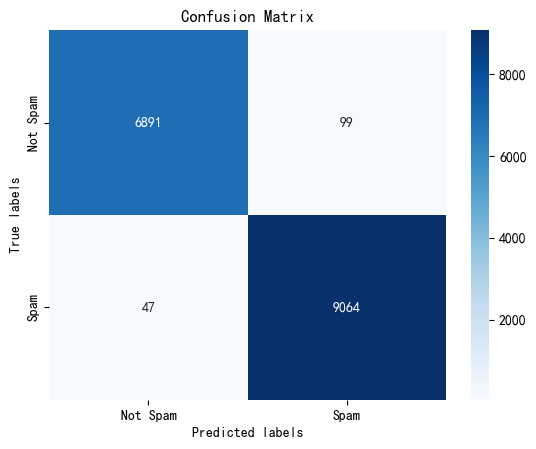

In [25]:
ax= plt.subplot()
#annot=True to annotate cells
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt='');
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam']);

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, accuracy_score
import joblib

In [27]:
# 创建决策树模型
model = DecisionTreeClassifier(random_state=42)

# 训练模型
model.fit(X_train_padded, y_train_encoded)
joblib.dump(model, 'save_model/dt/DT.pkl')

['save_model/dt/DT.pkl']

In [28]:
y_pred = model.predict(X_test_padded)
y_predict = [1 if o > 0.5 else 0 for o in y_pred]

In [29]:
cf_matrix =confusion_matrix(y_test_encoded,y_predict)
tn, fp, fn, tp = confusion_matrix(y_test_encoded,y_predict).ravel()
print("Precision: {:.2f}%".format(100 * precision_score(y_test_encoded, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test_encoded, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(y_test_encoded,y_predict)))

Precision: 86.01%
Recall: 85.74%
F1 Score: 85.87%


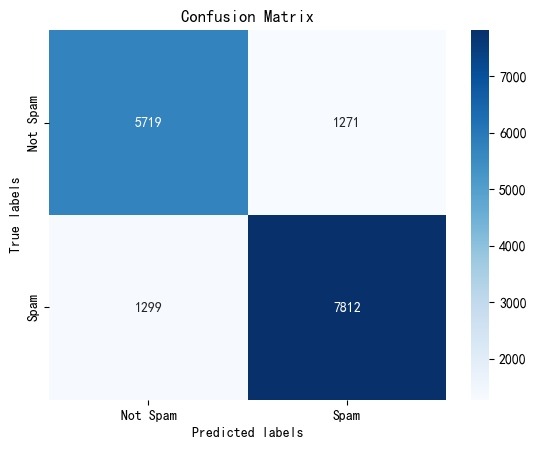

In [30]:
ax= plt.subplot()
#annot=True to annotate cells
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt='');
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam']);